<h2> Important points to consider: </h2>

   1) The panel is at the inventor x patent level - for patent / team level results I need to drop duplicates!
    
Design a set of basic descriptive statistics that I can run through with various model specifications and check how the results change when changing the:
 * Number of topics
 * Alpha and Eta specifications
 * Full text descriptions
 
 
Specifications
 * Alpha and Eta are auto
 * K = 10
 * Iterations = 100
 * Eval every = 5
 * Random State = 1234


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

C:\Users\Hannes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Hannes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
intermediate_outputs_path = "C:/Users/Hannes/Documents/Joe/TeamsAndText/IntermediateOutputs"
results_path = "C:/Users/Hannes/Documents/Joe/TeamsAndText/Results"

In [3]:
panel = pd.read_csv(f"{results_path}/document_data.csv")
panel.head()

,doc_id,inventor_number,alpha_i,patent_number,inventor_id,team_id,patent_distance,team_size,inventor_distance,D_team,...,citations,xi_real,subsection_id,birthyear,cpc_class_count,patents_in_year,patent_count_lagged,year_granted,permno_adj,geo_distance
0,0,455309,1.000000,5077839,fl:st_ln:keller-13,0,0.292571,1,0.321519,NaN,...,42.0,4.078859,A42,1953.0,4.0,2.0,0.0,1992,56573,NaN
1,1,97228,0.255909,5077870,fl:da_ln:bychinski-1,360041,0.387607,5,0.415432,0.359408,...,325.0,3.737033,A44,1960.0,5.0,1.0,0.0,1992,22592,166.012479
2,1,295597,0.150625,5077870,fl:le_ln:wood-3,360041,0.387607,5,0.465787,0.359408,...,325.0,3.737033,A44,1952.0,5.0,2.0,7.0,1992,22592,166.012479
3,1,314490,0.211713,5077870,fl:ma_ln:lindseth-1,360041,0.387607,5,0.339747,0.359408,...,325.0,3.737033,A44,1972.0,5.0,1.0,0.0,1992,22592,166.012479
4,1,464950,0.223438,5077870,fl:su_ln:nestegard-1,360041,0.387607,5,0.305534,0.359408,...,325.0,3.737033,A44,1961.0,5.0,4.0,5.0,1992,22592,166.012479


In [4]:
mean_alphas = [np.nanmedian(panel[panel["team_size"] == t]["alpha_i"]) for t in np.arange(2, 6)]
mean_alphas

[0.5, 0.3340047502897666, 0.2508548935028763, 0.20082707293790242]

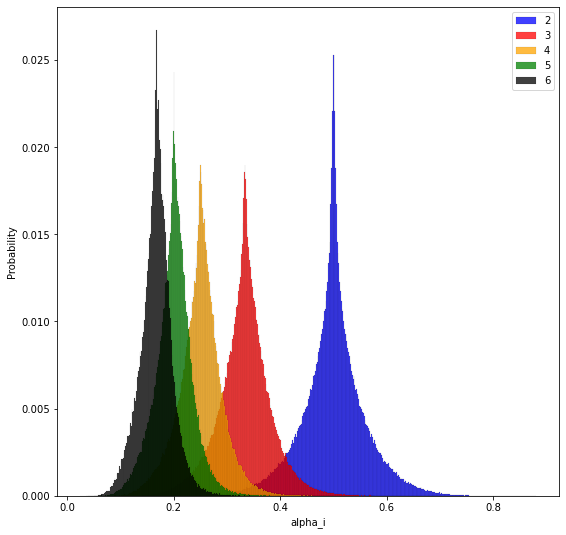

In [5]:
fig, ax = plt.subplots(figsize = (9,9))
sns.histplot(panel[panel["team_size"] == 2]["alpha_i"], label="2", color="blue", stat="probability", ax=ax)
sns.histplot(panel[panel["team_size"] == 3]["alpha_i"], label="3", color="red", stat="probability", ax=ax)
sns.histplot(panel[panel["team_size"] == 4]["alpha_i"], label="4", color="orange", stat="probability", ax=ax)
sns.histplot(panel[panel["team_size"] == 5]["alpha_i"], label="5", color="green", stat="probability", ax=ax)
sns.histplot(panel[panel["team_size"] == 6]["alpha_i"], label="6", color="black", stat="probability", ax=ax)
plt.legend()

Create relevant statistics

In [6]:
panel["log_citations"] = np.log(panel["citations"] + 1)

Create a histogram of patent and inventor distances from the center

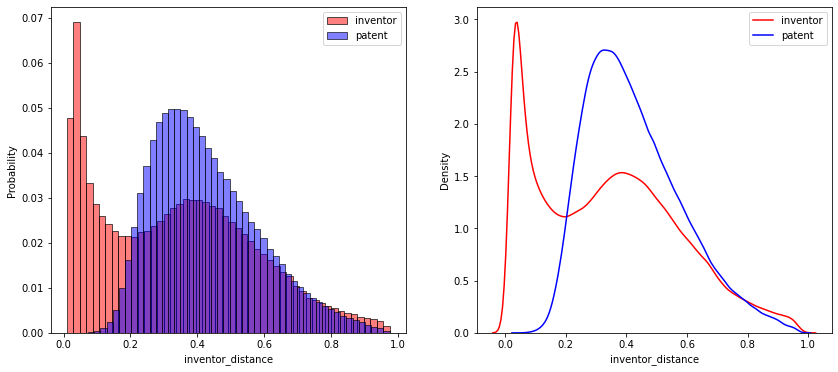

In [7]:
nbins = 50
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
reg_data = panel["inventor_distance"]
reg_data.drop_duplicates(inplace=True)
sns.histplot(x=reg_data, bins=nbins, stat="probability", color="red", alpha=0.5, label="inventor", ax=ax1)
sns.kdeplot(x=reg_data, color="red", label="inventor", ax=ax2)
ax1.legend()
ax2.legend()

reg_data = panel["patent_distance"]
reg_data.drop_duplicates(inplace=True)
sns.histplot(x=reg_data, bins=nbins, stat="probability", color="blue", alpha=0.5, label="patent", ax=ax1)
sns.kdeplot(x=reg_data, color="blue", label="patent", ax=ax2)
ax1.legend()
ax2.legend()

You can't really compare these distributions as the alpha measure is weighted down for larger teams. Or is it since the measure is multiplied by team size?

C:\Users\Hannes\AppData\Local\Temp/ipykernel_6160/2964331721.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data.drop_duplicates(inplace=True)


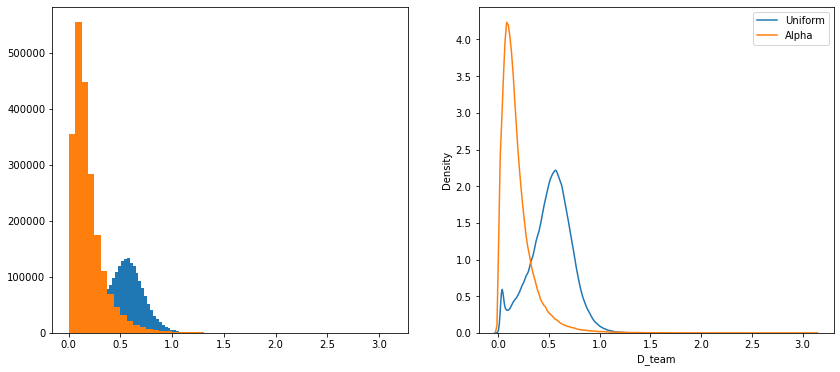

In [8]:
nbins = 50
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
reg_data = panel[["D_team", "D_team_alpha"]]
reg_data.drop_duplicates(inplace=True)
ax1.hist(panel["D_team"], bins=nbins, label="Uniform")
ax1.hist(panel["D_team_alpha"], bins=nbins, label="Alpha")
sns.kdeplot(x=panel["D_team"], label="Uniform", ax=ax2)
sns.kdeplot(x=panel["D_team_alpha"], label="Alpha", ax=ax2)
plt.legend()

Is the order in which inventors are listed on a patent informative of their contribution share?

In [9]:
reg_data = panel[panel["team_size"] == 4][["alpha_i", "inventor_sequence", "team_size"]]
reg_data.dropna(inplace=True)
x = reg_data[["inventor_sequence", "team_size"]]
y = reg_data["alpha_i"]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                alpha_i   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1460.
Date:                Wed, 30 Nov 2022   Prob (F-statistic):          7.64e-319
Time:                        14:50:50   Log-Likelihood:             7.2713e+05
No. Observations:              409908   AIC:                        -1.454e+06
Df Residuals:                  409906   BIC:                        -1.454e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
inventor_sequence    -0.0022   5.74e-0

C:\Users\Hannes\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


Plot distance on outcome measures

<AxesSubplot:xlabel='patent_distance', ylabel='log_citations'>

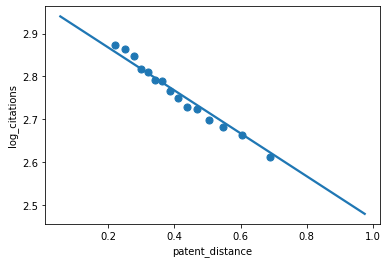

In [10]:
reg_data = panel[["log_citations", "patent_distance"]]
reg_data = reg_data.drop_duplicates()
sns.regplot(y="log_citations", x="patent_distance", data=reg_data, x_bins=15, ci=3)

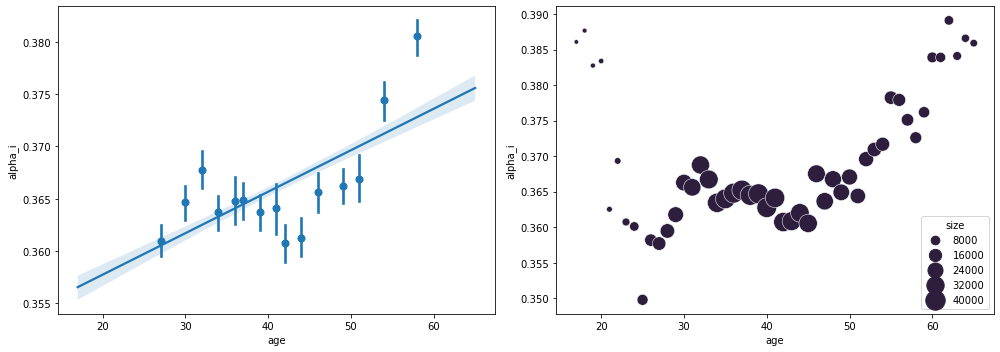

In [11]:
panel["age"] = panel["year"] - panel["birthyear"]
panel[(panel["age"] <= 16) | (panel["age"] > 65)] = np.nan
panel["age_quantiles"] = pd.qcut(panel['age'], q=10, labels=[10,9,8,7,6,5,4,3,2,1])
average_alpha = panel.groupby("age")["alpha_i"].mean()
average_alpha = pd.DataFrame(average_alpha)
age_size = dict(panel.groupby("age")["alpha_i"].count())
average_alpha["size"] = average_alpha.index.map(age_size)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
sns.regplot(y="alpha_i", x="age", data=panel, x_bins=15, ax=ax1)

sns.scatterplot(y=average_alpha["alpha_i"], x=average_alpha.index,
                hue=average_alpha["size"], size=average_alpha["size"],
                sizes=(20, 400), hue_norm=(0, 100), ax=ax2)
plt.tight_layout()

Do the same with experience- number of rpevioius patetnts


In [12]:
experience_stats = panel["patent_count_lagged"].describe()
experience_stats

count    2.335576e+06
mean     1.365215e+01
std      3.234730e+01
min      0.000000e+00
25%      1.000000e+00
50%      4.000000e+00
75%      1.400000e+01
max      4.557000e+03
Name: patent_count_lagged, dtype: float64

<AxesSubplot:xlabel='patent_count_lagged', ylabel='alpha_i'>

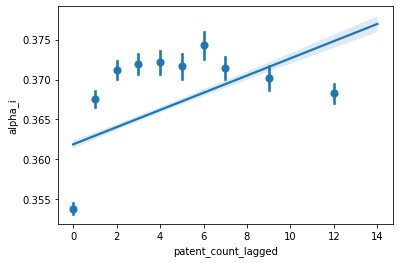

In [13]:
reg_data = panel[panel["patent_count_lagged"] <= experience_stats["75%"]]
sns.regplot(y="alpha_i", x="patent_count_lagged", data=reg_data, x_bins=15)

In [14]:
reg_data = panel[["alpha_i", "patent_count_lagged", "team_size"]]
reg_data["log_alpha"] = np.log(reg_data["alpha_i"])
reg_data.dropna(inplace=True)
x = reg_data[["patent_count_lagged", "team_size"]]
y = reg_data["log_alpha"]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

C:\Users\Hannes\AppData\Local\Temp/ipykernel_6160/3836029366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data["log_alpha"] = np.log(reg_data["alpha_i"])
C:\Users\Hannes\AppData\Local\Temp/ipykernel_6160/3836029366.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data.dropna(inplace=True)
C:\Users\Hannes\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:              log_alpha   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 3.144e+06
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:56:01   Log-Likelihood:            -7.6212e+05
No. Observations:             2335556   AIC:                         1.524e+06
Df Residuals:                 2335553   BIC:                         1.524e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.4266    

In [15]:
reg_data = panel[["alpha_i", "male_flag", "team_size"]]
reg_data["log_alpha"] = np.log(reg_data["alpha_i"])
reg_data = reg_data.dropna()
x = reg_data[["male_flag", "team_size"]]
y = reg_data["log_alpha"]
x = sm.add_constant(x)

model = sm.OLS(y, x).fit()
predictions = model.predict(x) 

print_model = model.summary()
print(print_model)

C:\Users\Hannes\AppData\Local\Temp/ipykernel_6160/1224437313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data["log_alpha"] = np.log(reg_data["alpha_i"])
C:\Users\Hannes\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:              log_alpha   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                 3.053e+06
Date:                Wed, 30 Nov 2022   Prob (F-statistic):               0.00
Time:                        14:56:02   Log-Likelihood:            -7.3451e+05
No. Observations:             2261391   AIC:                         1.469e+06
Df Residuals:                 2261388   BIC:                         1.469e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4545      0.001   -575.448      0.0

In [16]:
reg_data = panel[["team_id", "xi_real", "log_citations", "D_team_alpha", "D_team"]]
reg_data = reg_data.drop_duplicates()
reg_data

,team_id,xi_real,log_citations,D_team_alpha,D_team
0,0.0,4.078859,3.761200,NaN,NaN
1,360041.0,3.737033,5.786897,0.076443,0.359408
6,360040.0,8.724542,4.060443,0.125834,0.167108
9,360039.0,16.207052,3.610918,0.126639,0.292138
18,360038.0,1.135044,4.905275,0.141764,0.669447
...,...,...,...,...,...
2390755,180007.0,NaN,NaN,0.117303,0.426020
2390759,270025.0,NaN,NaN,0.088639,0.243874
2390762,174357.0,NaN,NaN,NaN,NaN
2390763,540053.0,NaN,NaN,0.295402,0.615948


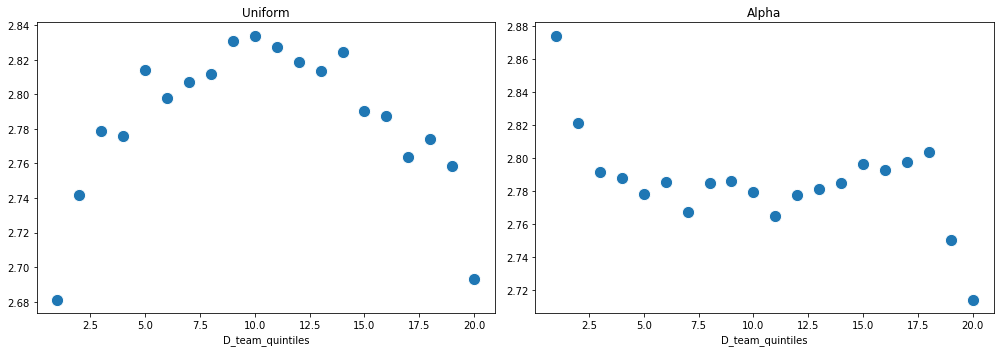

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
marker_size = 150

# Uniform measure
reg_data["D_team_quintiles"] = pd.qcut(reg_data['D_team'], q=20, labels=np.arange(start=20, stop=0, step=-1))
average_alpha = reg_data.groupby("D_team_quintiles")["log_citations"].mean()

sns.scatterplot(y=average_alpha.values, x=average_alpha.index, s=marker_size, ax=ax1)
ax1.set_title("Uniform")


# Alpha measure
reg_data["D_team_quintiles"] = pd.qcut(reg_data['D_team_alpha'], q=20, labels=np.arange(start=20, stop=0, step=-1))
average_alpha = reg_data.groupby("D_team_quintiles")["log_citations"].mean()

sns.scatterplot(y=average_alpha.values, x=average_alpha.index, s=marker_size, ax=ax2)

ax2.set_title("Alpha")

plt.tight_layout()

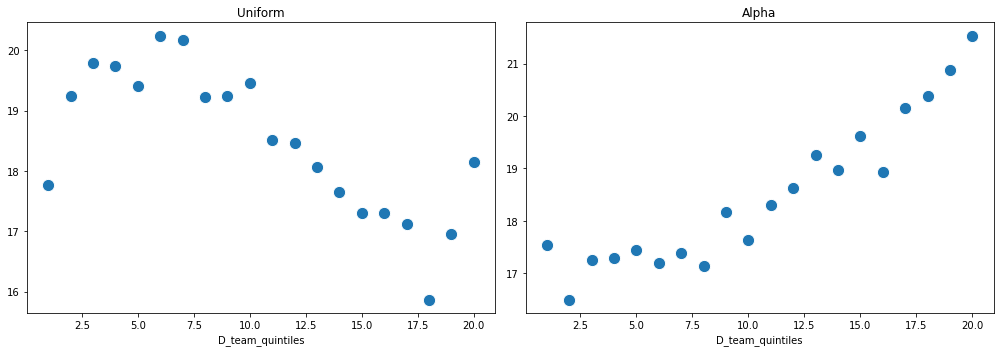

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14,5))

# Uniform measure
reg_data["D_team_quintiles"] = pd.qcut(reg_data['D_team'], q=20, labels=np.arange(start=20, stop=0, step=-1))
average_alpha = reg_data.groupby("D_team_quintiles")["xi_real"].mean()

sns.scatterplot(y=average_alpha.values, x=average_alpha.index, s=marker_size, ax=ax1)
ax1.set_title("Uniform")


# Alpha measure
reg_data["D_team_quintiles"] = pd.qcut(reg_data['D_team_alpha'], q=20, labels=np.arange(start=20, stop=0, step=-1))
average_alpha = reg_data.groupby("D_team_quintiles")["xi_real"].mean()

sns.scatterplot(y=average_alpha.values, x=average_alpha.index, s=marker_size, ax=ax2)

ax2.set_title("Alpha")

plt.tight_layout()